In [ ]:
pip install databento

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 71.5 MB/s eta 0:00:00


In [ ]:
import databento
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

api_key = 'YOUR_API_KEY'

client = databento.Historical(api_key)

# Specify dataset parameters
dataset = 'XNAS.ITCH'
symbols = ['AAPL', 'MSFT', 'NVDA', 'AMGN', 'GILD', 'TSLA', 'PEP', 'JPM', 'V', 'XOM']
start_date = '2022-01-01'
end_date = '2022-01-31'

# Fetch data
data = client.timeseries.get_range(
    dataset=dataset,
    schema='mbp-10',
    start=start_date,
    end=end_date,
    limit=100_000,
    symbols=",".join(symbols)
)


data.to_csv('order_book_data.csv')

# Load the data
data = pd.read_csv('order_book_data.csv')

# Data Cleaning
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['ts_recv'])
data.sort_values(by=['symbol', 'timestamp'], inplace=True)
data.drop_duplicates(inplace=True)



In [ ]:
# Multi-level OFI calculation

def calculate_mlofi(group, levels=5):
    mlofi = pd.DataFrame(index=group.index)
    mlofi['symbol'] = group['symbol']
    for i in range(levels):
        bid_col = f'bid_sz_{i:02d}'
        ask_col = f'ask_sz_{i:02d}'
        mlofi[f'ofi_{i}'] = group[bid_col].diff().fillna(0) - group[ask_col].diff().fillna(0)
    return mlofi

In [ ]:

ofi_data = data.groupby('symbol', group_keys=False).apply(calculate_mlofi).reset_index()



In [ ]:
print(ofi_data.columns)


Index(['index', 'symbol', 'ofi_0', 'ofi_1', 'ofi_2', 'ofi_3', 'ofi_4'], dtype='object')


In [ ]:
def apply_pca(group):
    ofi_features = [f'ofi_{i}' for i in range(5)]
    pca = PCA(n_components=1)
    group_clean = group[ofi_features].dropna()
    if len(group_clean) > 0:
        group['ofi_pca'] = pd.Series(pca.fit_transform(group_clean).flatten(), index=group_clean.index)
        print(f"PCA applied for symbol {group['symbol'].iloc[0]}: {group['ofi_pca']}")
    else:
        group['ofi_pca'] = np.nan
    return group

In [ ]:
print(ofi_data.columns)
print(ofi_data.head())

Index(['index', 'symbol', 'ofi_0', 'ofi_1', 'ofi_2', 'ofi_3', 'ofi_4',
       'ofi_pca'],
      dtype='object')
   index symbol  ofi_0  ofi_1  ofi_2  ofi_3  ofi_4    ofi_pca
0    511   AAPL    0.0    0.0    0.0    0.0    0.0  -0.030665
1    512   AAPL    0.0    0.0    0.0    0.0    0.0  -0.030665
2    546   AAPL    0.0  -29.0   28.0    1.0  -19.0 -12.537688
3    547   AAPL    0.0    1.0    0.0    0.0    0.0   0.274608
4    549   AAPL    0.0    1.0    0.0    0.0    0.0   0.274608


In [ ]:
# Now apply PCA after ensuring that the MLOFI columns exist
ofi_data = ofi_data.groupby('symbol', group_keys=False).apply(apply_pca).reset_index(drop=False)


In [ ]:
def calculate_price_changes(group):
    group['price_change'] = group['ofi_pca'].diff()
    group['future_price_change_1min'] = group['ofi_pca'].diff().shift(-60)  # Assuming 1-second intervals
    group['future_price_change_5min'] = group['ofi_pca'].diff().shift(-300)
    return group

ofi_data = ofi_data.groupby('symbol', group_keys=False).apply(calculate_price_changes).reset_index(drop=True)

# Calculate lagged OFI
ofi_data['ofi_lagged'] = ofi_data.groupby('symbol')['ofi_pca'].shift(1)

# Remove rows with NaN values in important columns
important_columns = ['ofi_pca', 'price_change', 'future_price_change_1min', 'future_price_change_5min', 'ofi_lagged']
ofi_data_cleaned = ofi_data.dropna(subset=important_columns)


In [ ]:
print(ofi_data.isnull().sum())
numeric_columns = ofi_data.select_dtypes(include=[np.number]).columns
print(np.isinf(ofi_data[numeric_columns]).sum())
ofi_data_cleaned[numeric_columns] = ofi_data_cleaned[numeric_columns].replace([np.inf, -np.inf], np.nan)

level_0                        0
index                          0
symbol                         0
ofi_0                          0
ofi_1                          0
ofi_2                          0
ofi_3                          0
ofi_4                          0
ofi_pca                        0
price_change                  10
future_price_change_1min     553
future_price_change_5min    2713
ofi_lagged                    10
dtype: int64
level_0                     0
index                       0
ofi_0                       0
ofi_1                       0
ofi_2                       0
ofi_3                       0
ofi_4                       0
ofi_pca                     0
price_change                0
future_price_change_1min    0
future_price_change_5min    0
ofi_lagged                  0
dtype: int64


In [ ]:
# Remove rows with NaN values in important columns
important_columns = ['price_change', 'future_price_change_1min', 'future_price_change_5min', 'ofi_lagged']
ofi_data_cleaned = ofi_data.dropna(subset=important_columns)

# Check for infinite values in numeric columns and replace them with NaN
numeric_columns = ofi_data_cleaned.select_dtypes(include=[np.number]).columns
ofi_data_cleaned[numeric_columns] = ofi_data_cleaned[numeric_columns].replace([np.inf, -np.inf], np.nan)

# Remove any remaining rows with NaN values
ofi_data_cleaned = ofi_data_cleaned.dropna()

print(ofi_data_cleaned.isnull().sum())
print(np.isinf(ofi_data_cleaned[numeric_columns]).sum())


level_0                     0
index                       0
symbol                      0
ofi_0                       0
ofi_1                       0
ofi_2                       0
ofi_3                       0
ofi_4                       0
ofi_pca                     0
price_change                0
future_price_change_1min    0
future_price_change_5min    0
ofi_lagged                  0
dtype: int64
level_0                     0
index                       0
ofi_0                       0
ofi_1                       0
ofi_2                       0
ofi_3                       0
ofi_4                       0
ofi_pca                     0
price_change                0
future_price_change_1min    0
future_price_change_5min    0
ofi_lagged                  0
dtype: int64


In [ ]:
def run_regression(data, y_col, x_cols):
    df = data[[y_col] + x_cols].copy()
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    if df.empty:
        print(f"No valid data for regression with y={y_col} and x={x_cols}")
        return None

    X = sm.add_constant(df[x_cols])
    y = df[y_col]

    model = sm.OLS(y, X).fit()
    return model

In [ ]:
# Remove rows with inf or NaN values in important columns
important_columns = ['ofi_pca', 'price_change', 'future_price_change_1min', 'future_price_change_5min', 'ofi_lagged']
ofi_data_cleaned = ofi_data[important_columns].replace([np.inf, -np.inf], np.nan).dropna()

print("Original shape:", ofi_data.shape)
print("Cleaned shape:", ofi_data_cleaned.shape)


Original shape: (93093, 13)
Cleaned shape: (90371, 5)


In [ ]:
# Contemporaneous model
contemp_model = run_regression(ofi_data_cleaned, 'price_change', ['ofi_pca'])
if contemp_model:
    print("Contemporaneous Model:")
    print(contemp_model.summary())

# Predictive model (1-minute horizon)
pred_model_1min = run_regression(ofi_data_cleaned, 'future_price_change_1min', ['ofi_lagged'])
if pred_model_1min:
    print("\nPredictive Model (1-minute horizon):")
    print(pred_model_1min.summary())

# Predictive model (5-minute horizon)
pred_model_5min = run_regression(ofi_data_cleaned, 'future_price_change_5min', ['ofi_lagged'])
if pred_model_5min:
    print("\nPredictive Model (5-minute horizon):")
    print(pred_model_5min.summary())


Contemporaneous Model:
                            OLS Regression Results                            
Dep. Variable:           price_change   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                 1.631e+05
Date:                Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:11:32   Log-Likelihood:            -6.3121e+05
No. Observations:               90371   AIC:                         1.262e+06
Df Residuals:                   90369   BIC:                         1.262e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0301      0.

In [ ]:
important_columns = ['symbol', 'ofi_pca', 'price_change', 'future_price_change_1min', 'future_price_change_5min', 'ofi_lagged']

numeric_columns = [col for col in important_columns if col != 'symbol']
ofi_data_cleaned = ofi_data[important_columns].copy()
ofi_data_cleaned[numeric_columns] = ofi_data_cleaned[numeric_columns].replace([np.inf, -np.inf], np.nan)
ofi_data_cleaned = ofi_data_cleaned.dropna()

# Check the shape of the cleaned dataset
print("Original shape:", ofi_data.shape)
print("Cleaned shape:", ofi_data_cleaned.shape)



Original shape: (93093, 13)
Cleaned shape: (90371, 6)


In [ ]:
# Cross-impact analysis
correlation_columns = [col for col in important_columns if col != 'symbol']
correlation_matrix = ofi_data_cleaned.groupby('symbol')[correlation_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cross-Impact Relationships')
plt.tight_layout()
plt.savefig('cross_impact_heatmap.png')
plt.close()

# Print the correlation matrix
print(correlation_matrix)


                                  ofi_pca  price_change  \
symbol                                                    
AAPL   ofi_pca                   1.000000      0.794457   
       price_change              0.794457      1.000000   
       future_price_change_1min  0.023361      0.006062   
       future_price_change_5min -0.033716     -0.030316   
       ofi_lagged               -0.262325     -0.794457   
AMGN   ofi_pca                   1.000000      0.776783   
       price_change              0.776783      1.000000   
       future_price_change_1min -0.010683     -0.042764   
       future_price_change_5min  0.011020      0.007129   
       ofi_lagged               -0.205555     -0.775991   
GILD   ofi_pca                   1.000000      0.846637   
       price_change              0.846637      1.000000   
       future_price_change_1min  0.022823      0.011204   
       future_price_change_5min  0.028916      0.035963   
       ofi_lagged               -0.433420     -0.846538 

In [ ]:
print(ofi_data_cleaned.describe())
print(ofi_data_cleaned.dtypes)

            ofi_pca  price_change  future_price_change_1min  \
count  90371.000000  90371.000000              90371.000000   
mean      -0.021304      0.002699                  0.011439   
std      272.795581    437.647863                437.052515   
min    -8074.352875 -16122.793460             -16122.793460   
25%       -0.726710    -28.510124                -28.675702   
50%       -0.006244      0.000000                  0.000000   
75%        0.830262     31.700496                 31.984603   
max     8073.636496  13561.445950              13561.445950   

       future_price_change_5min    ofi_lagged  
count              90371.000000  90371.000000  
mean                  -0.000927     -0.024003  
std                  439.443210    272.789324  
min               -16122.793460  -8074.352875  
25%                  -30.261421     -0.726710  
50%                    0.000000     -0.006244  
75%                   32.714820      0.830262  
max                13561.445950   8073.636496  


In [ ]:
overall_correlation = ofi_data_cleaned[correlation_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(overall_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Overall Cross-Impact Relationships')
plt.tight_layout()
plt.savefig('overall_cross_impact_heatmap.png')
plt.close()

print("Overall Correlation Matrix:")
print(overall_correlation)


Overall Correlation Matrix:
                           ofi_pca  price_change  future_price_change_1min  \
ofi_pca                   1.000000      0.802168                 -0.005224   
price_change              0.802168      1.000000                 -0.010603   
future_price_change_1min -0.005224     -0.010603                  1.000000   
future_price_change_5min  0.013189      0.013484                  0.012546   
ofi_lagged               -0.286930     -0.802158                  0.011787   

                          future_price_change_5min  ofi_lagged  
ofi_pca                                   0.013189   -0.286930  
price_change                              0.013484   -0.802158  
future_price_change_1min                  0.012546    0.011787  
future_price_change_5min                  1.000000   -0.008443  
ofi_lagged                               -0.008443    1.000000  


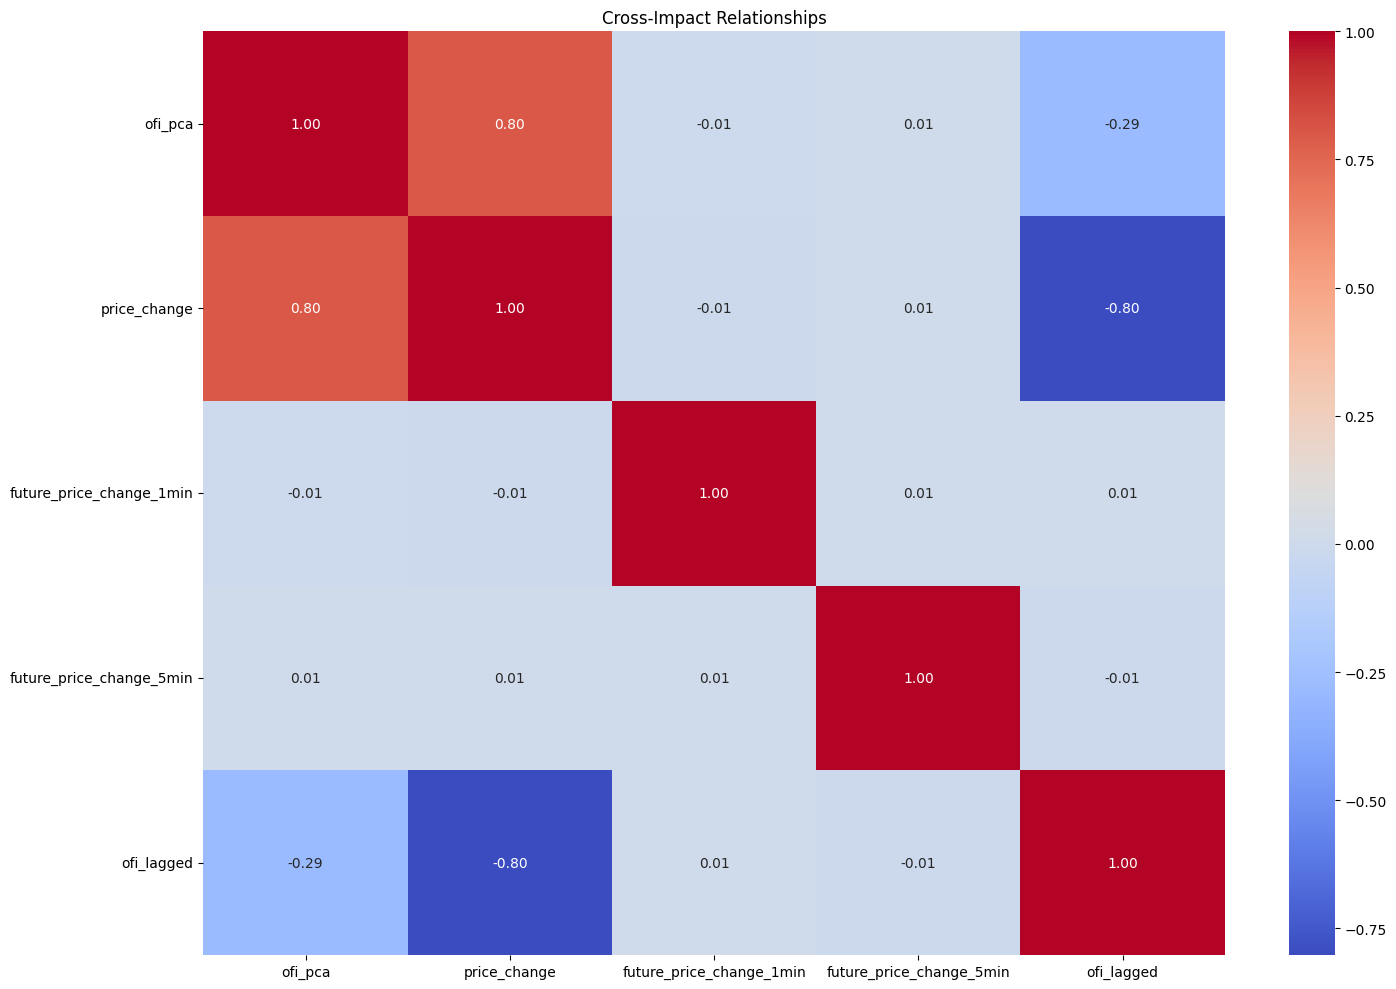

In [ ]:
correlation_columns = ['ofi_pca', 'price_change', 'future_price_change_1min', 'future_price_change_5min', 'ofi_lagged']
correlation_matrix = ofi_data_cleaned[correlation_columns].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=np.isnan(correlation_matrix))
plt.title('Cross-Impact Relationships')
plt.tight_layout()
plt.savefig('cross_impact_heatmap.png')
plt.show()



In [ ]:
print(ofi_data.columns)

Index(['level_0', 'index', 'symbol', 'ofi_0', 'ofi_1', 'ofi_2', 'ofi_3',
       'ofi_4', 'ofi_pca', 'price_change', 'future_price_change_1min',
       'future_price_change_5min', 'ofi_lagged'],
      dtype='object')


In [ ]:
def cross_impact_analysis(data):
    symbols = data['symbol'].unique()
    impact_matrix = pd.DataFrame(index=symbols, columns=symbols, dtype=float)

    for symbol1 in symbols:
        for symbol2 in symbols:
            try:
                # Get data for both symbols
                data1 = data[data['symbol'] == symbol1]['ofi_pca'].values
                data2 = data[data['symbol'] == symbol2]['price_change'].values

                # Ensure equal length for correlation
                min_length = min(len(data1), len(data2))
                if min_length > 0:
                    # Calculate correlation between OFI and price changes
                    correlation = np.corrcoef(data1[:min_length], data2[:min_length])[0,1]
                    impact_matrix.loc[symbol1, symbol2] = correlation if np.isfinite(correlation) else np.nan
                else:
                    print(f"Insufficient data for {symbol1} and {symbol2}")
                    impact_matrix.loc[symbol1, symbol2] = np.nan

            except Exception as e:
                print(f"Error calculating correlation between {symbol1} and {symbol2}: {e}")
                impact_matrix.loc[symbol1, symbol2] = np.nan

    return impact_matrix


In [ ]:
# Calculate cross-impact matrix
cross_impact = cross_impact_analysis(ofi_data_cleaned)

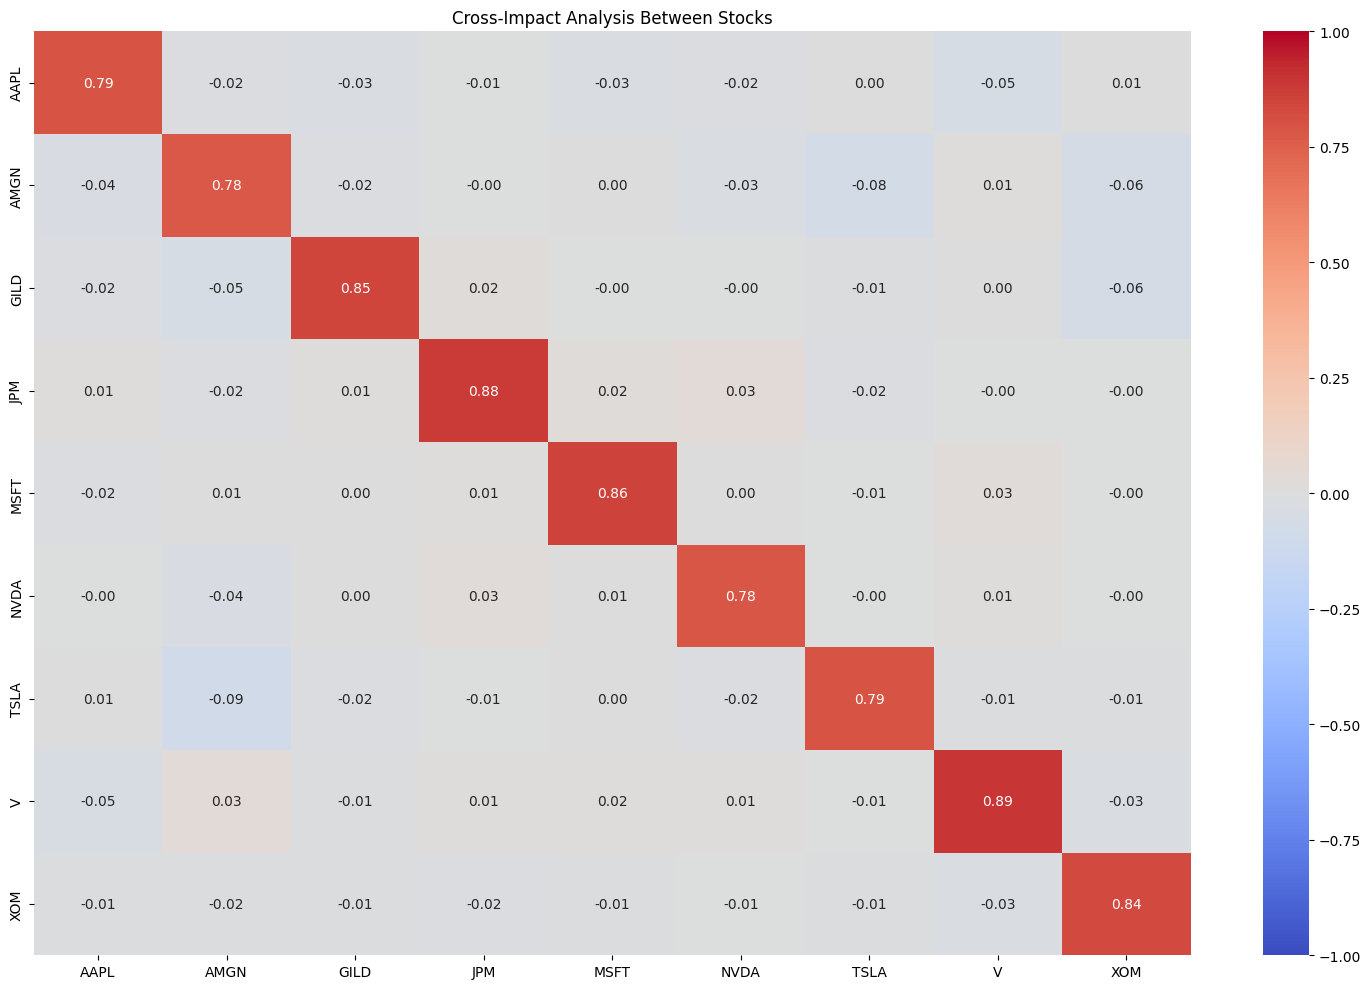

In [ ]:
# Visualization of cross-impact relationships
plt.figure(figsize=(15, 10))
mask = np.isnan(cross_impact)
sns.heatmap(cross_impact,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            mask=mask,
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Cross-Impact Analysis Between Stocks')
plt.tight_layout()
plt.savefig('cross_impact_heatmap.png')
plt.show()

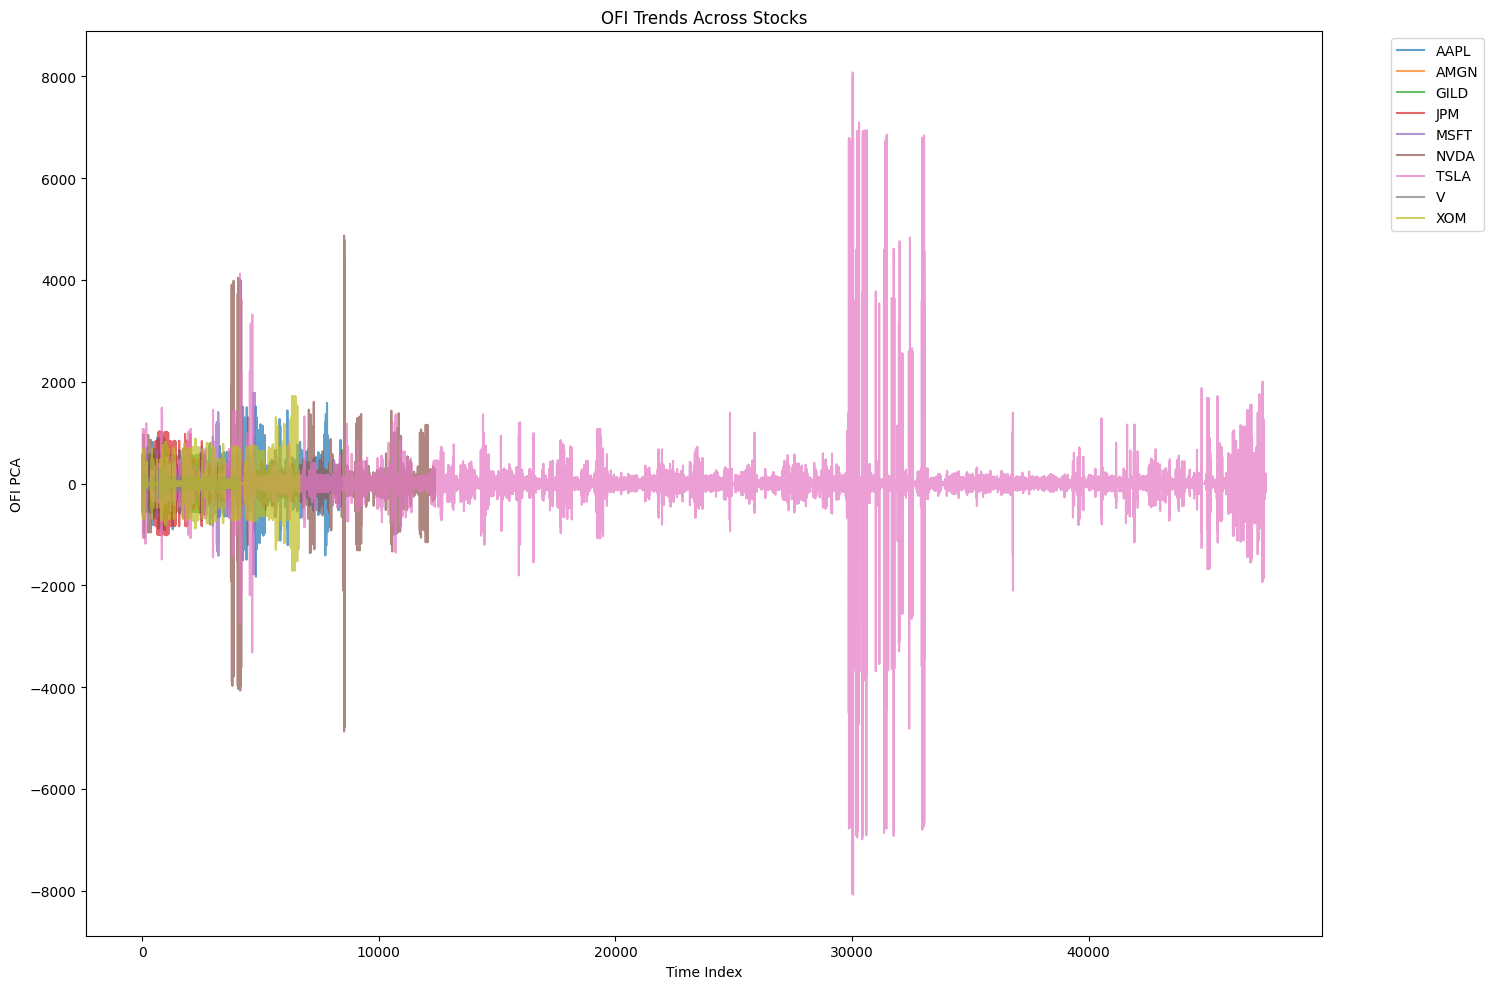

In [ ]:
#visualization: OFI trends over time
plt.figure(figsize=(15, 10))
for symbol in ofi_data_cleaned['symbol'].unique():
    symbol_data = ofi_data_cleaned[ofi_data_cleaned['symbol'] == symbol]
    plt.plot(range(len(symbol_data)), symbol_data['ofi_pca'], label=symbol, alpha=0.7)

plt.title('OFI Trends Across Stocks')
plt.xlabel('Time Index')
plt.ylabel('OFI PCA')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('ofi_trends.png')
plt.show()

In [ ]:
time_horizons = {
    'Contemporaneous': 'price_change',
    '1-min Future': 'future_price_change_1min',
    '5-min Future': 'future_price_change_5min'
}


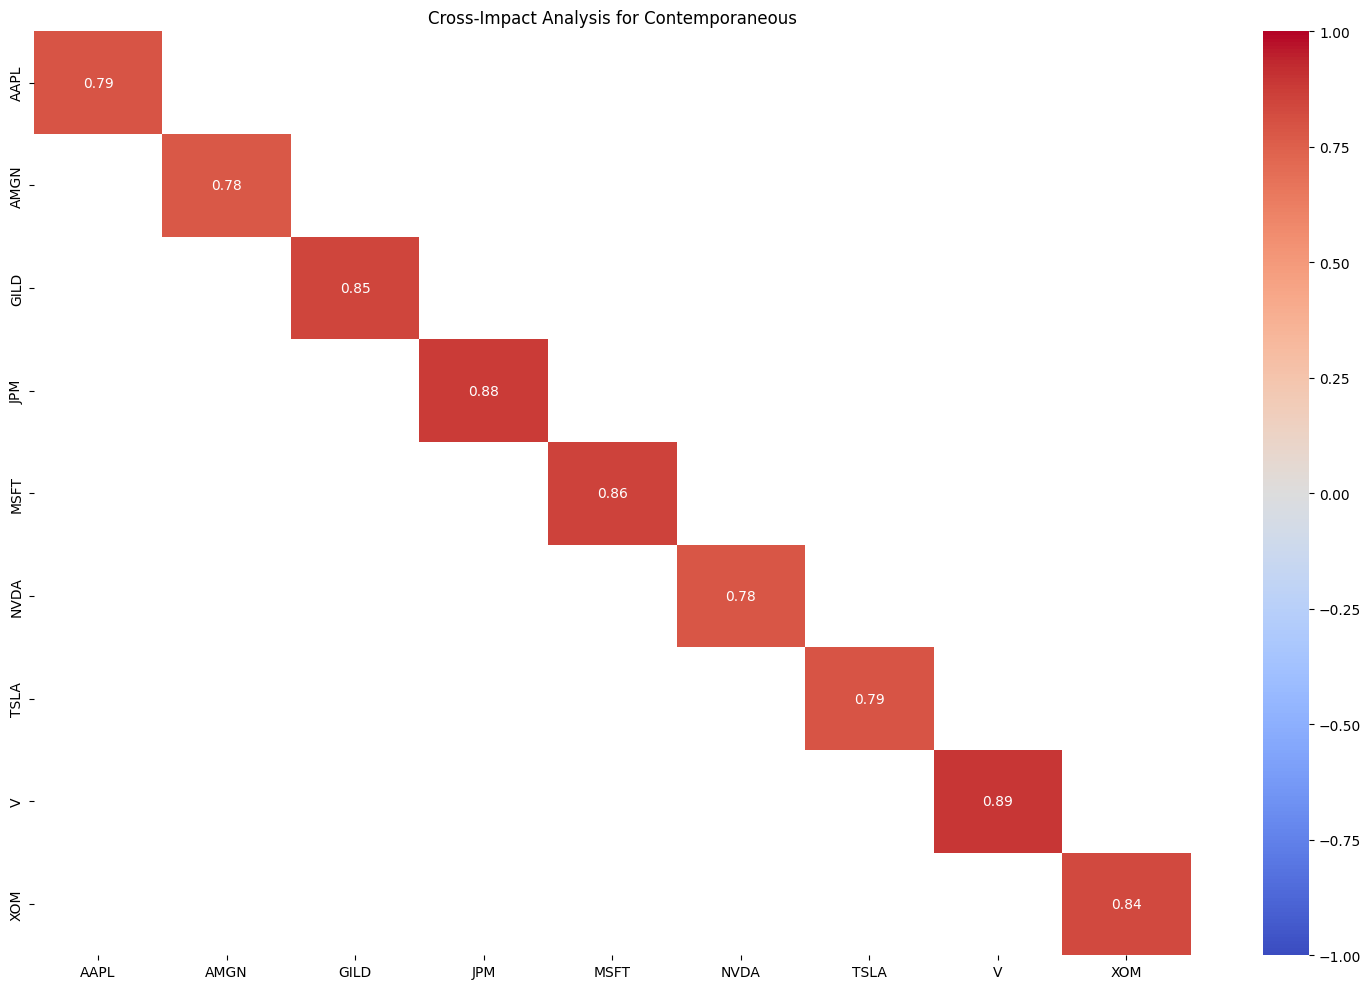

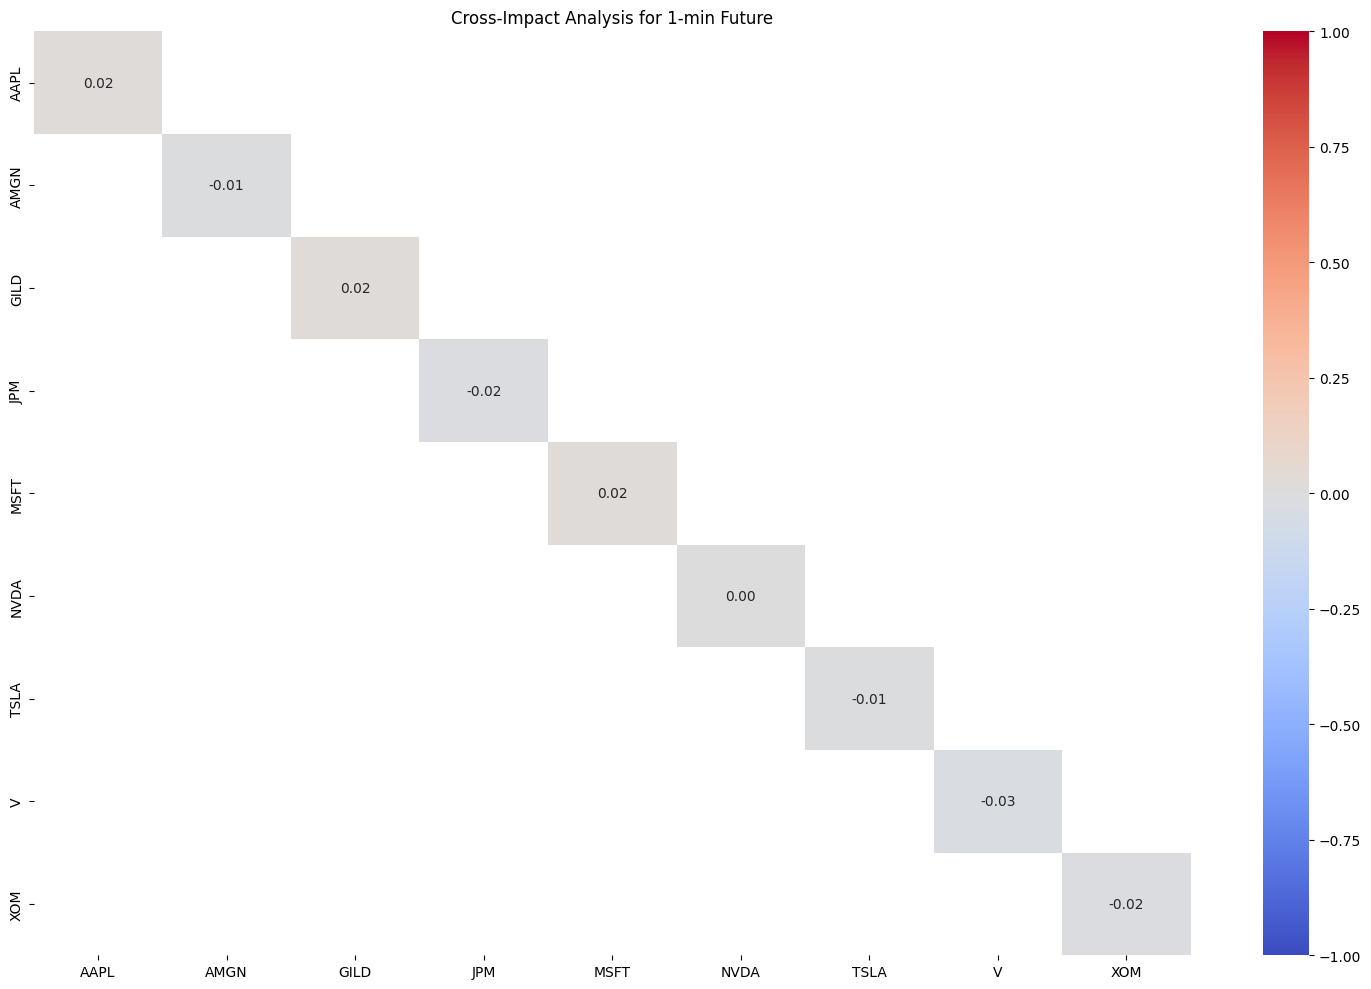

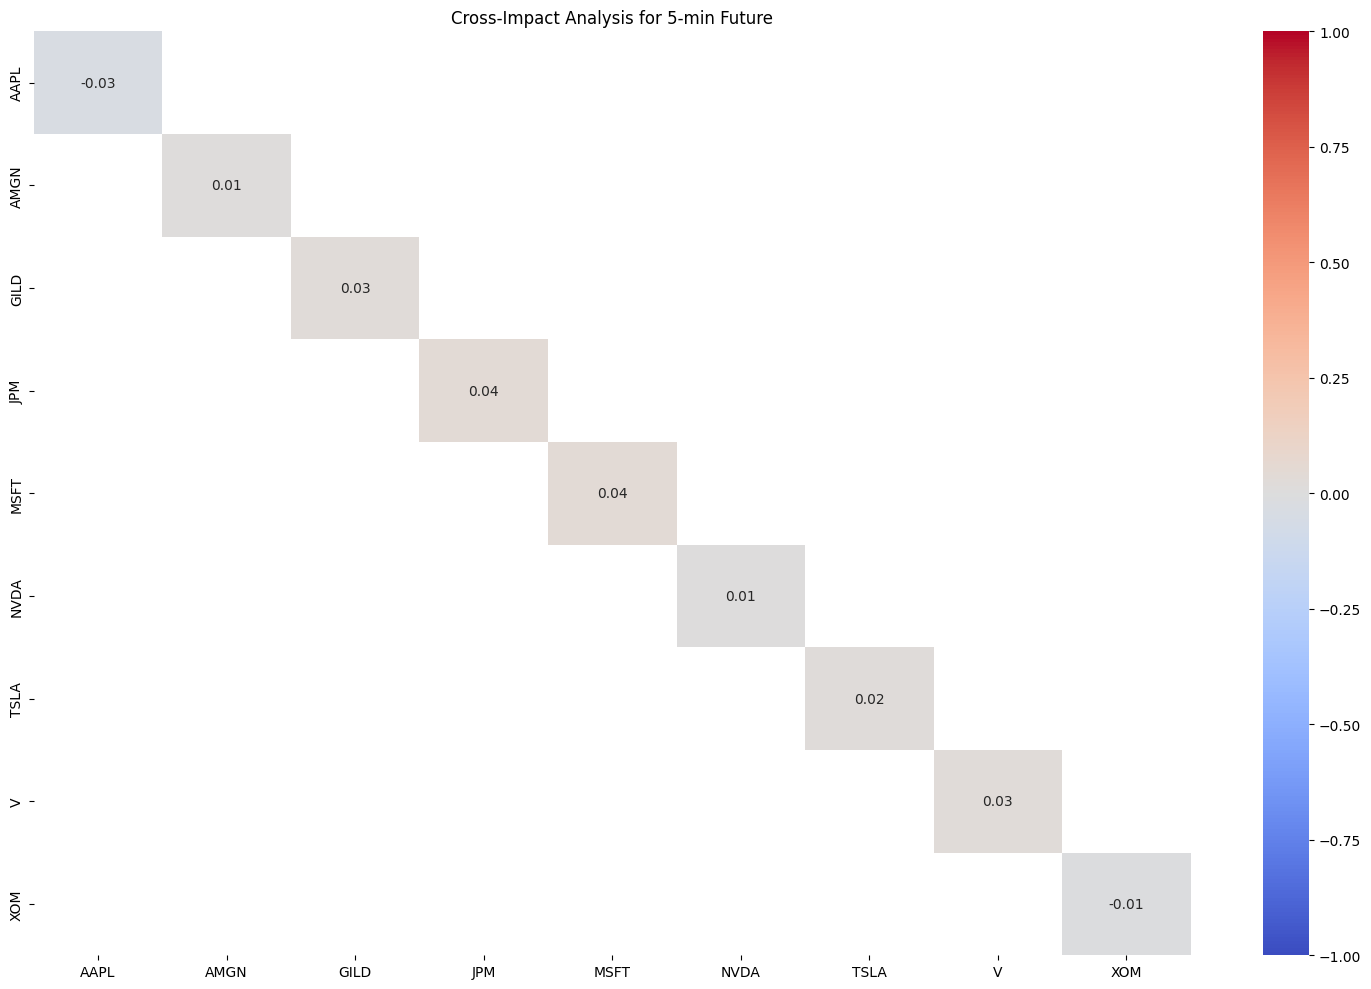

In [ ]:
for horizon_name, column in time_horizons.items():
    # Calculate correlations between stocks
    correlations = pd.DataFrame(index=ofi_data_cleaned['symbol'].unique(),
                              columns=ofi_data_cleaned['symbol'].unique(),
                              dtype=float)

    for symbol1 in correlations.index:
        for symbol2 in correlations.columns:
            data1 = ofi_data_cleaned[ofi_data_cleaned['symbol'] == symbol1]['ofi_pca']
            data2 = ofi_data_cleaned[ofi_data_cleaned['symbol'] == symbol2][column]

            # Ensure equal length for correlation calculation
            min_length = min(len(data1), len(data2))
            if min_length > 0:
                correlation = data1[:min_length].corr(data2[:min_length])
                correlations.loc[symbol1, symbol2] = correlation if np.isfinite(correlation) else np.nan


    plt.figure(figsize=(15, 10))
    mask = np.isnan(correlations)
    sns.heatmap(correlations,
                annot=True,
                cmap='coolwarm',
                fmt='.2f',
                mask=mask,
                center=0,
                vmin=-1,
                vmax=1)
    plt.title(f'Cross-Impact Analysis for {horizon_name}')
    plt.tight_layout()
    plt.savefig(f'cross_impact_{horizon_name.lower()}.png')
    plt.show()
